# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [2]:
# levantamos los datos
df = pd.read_csv('podcast_dataset.csv')

# peek
df.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3,Positive,55.158695
1,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral,7.686559
2,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3,Neutral,110.064645
3,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0,Positive,12.000380
4,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3,Positive,NaN


# Preprocessing

Ver notebook de EDA.

In [3]:
# drop duplicates
df.drop_duplicates(inplace=True)

# target relativo
df['fraction_listened'] = df['Listening_Time_minutes'] / df['Episode_Length_minutes']

# encoding de episode number
df['Episode_Number'] = df['Episode_Title'].apply(lambda x: x.split(" ")[-1]).astype(int)

# ausencia de guest
df['no_guest'] = df['Guest_Popularity_percentage'].isna()

# imputacion de NaNs
df.fillna({'Guest_Popularity_percentage':-1}, inplace=True)

# dropeo de NaNs de las otras columnas y reseteo de index
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

# encoding de sentiment
df['sentiment_encoded'] = df['Episode_Sentiment'].map({'Neutral':0, 'Negative':-1, 'Positive':1}).astype(int)

# drop de variables ahora redundantes
df.drop(columns=['Episode_Title', 'Episode_Sentiment'], inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40374 entries, 0 to 40373
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Podcast_Name                 40374 non-null  object 
 1   Episode_Length_minutes       40374 non-null  float64
 2   Genre                        40374 non-null  object 
 3   Host_Popularity_percentage   40374 non-null  float64
 4   Publication_Day              40374 non-null  object 
 5   Publication_Time             40374 non-null  object 
 6   Guest_Popularity_percentage  40374 non-null  float64
 7   Number_of_Ads                40374 non-null  int64  
 8   Listening_Time_minutes       40374 non-null  float64
 9   fraction_listened            40374 non-null  float64
 10  Episode_Number               40374 non-null  int32  
 11  no_guest                     40374 non-null  bool   
 12  sentiment_encoded            40374 non-null  int32  
dtypes: bool(1), floa

# Baseline

Para este problema elegimos minimizar el MSE/RMSE, aunque también miramos el MAE.

In [5]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
#from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from tqdm.notebook import tqdm

In [6]:
X = df.drop(columns=['Listening_Time_minutes','fraction_listened'])
y_abs = df['Listening_Time_minutes']
y_rel = df['fraction_listened']

In [7]:
numeric_cols = X.columns[X.dtypes!='object'].tolist()
numeric_cols

['Episode_Length_minutes',
 'Host_Popularity_percentage',
 'Guest_Popularity_percentage',
 'Number_of_Ads',
 'Episode_Number',
 'no_guest',
 'sentiment_encoded']

In [8]:
cat_cols = X.columns[X.dtypes=='object'].tolist()
cat_cols

['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time']

In [9]:
# utils
def rel_to_abs(y_pred_rel, X):
    return y_pred_rel * X['Episode_Length_minutes']

METRICS = {
    'mae': mean_absolute_error,
    'mse': mean_squared_error,
    'rmse': root_mean_squared_error,
}

SPLITTER = KFold(n_splits=5, random_state=42, shuffle=True)

def cv_model(model_constructor_f, X, is_rel, model_args={}):
    results = []
    models = []
    for i, (train_idx, test_idx) in tqdm(enumerate(SPLITTER.split(X)), 
                                         total=SPLITTER.get_n_splits()):
        X_train = X.loc[train_idx]
        X_test = X.loc[test_idx]

        y_train = y_rel[train_idx] if is_rel else y_abs[train_idx]
        y_test = y_abs[test_idx]

        # inst+fit model
        model = model_constructor_f(**model_args)

        model.fit(X_train, y_train)

        # predict
        y_pred = model.predict(X_test)

        # if rel, adjust to abs
        if is_rel:
            y_pred = rel_to_abs(y_pred, X_test)

        results.append({name:f(y_test, y_pred) for name,f in METRICS.items()})
        models.append(model)

    res_df = pd.DataFrame(results)
    # add mean and std values across folds for all metrics
    return pd.concat((res_df, res_df.describe().loc[['mean','std']])), models

In [10]:
# gráfico de importancias across-folds
# utils
def lr_weights(
        models: Pipeline | LinearRegression | list[Pipeline] | list[LinearRegression],
        feature_names: list[str],
        horizontal: bool = True,
        seed: int = 1234) -> None:
    if not isinstance(models, list):
        models = [models]
    if isinstance(models[0], Pipeline):
        models = [model[-1] for model in models]
    coefs = np.vstack([np.concatenate([*x.coef_, x.intercept_]) for x in models])
    df = pd.DataFrame(coefs, columns=feature_names+['intercept'])
    ax = sns.barplot(df, orient='h' if horizontal else 'v', seed=seed)
    ax.set_title(f"LR coefficients across evaluation procedure")
    plt.show()

def rf_importance(
        models: Pipeline | RandomForestRegressor | list[RandomForestRegressor] | list[Pipeline],
        feature_names: list[str],
        horizontal: bool = True,
        seed: int = 1234) -> None:
    if not isinstance(models, list):
        models = [models]
    if isinstance(models[0], Pipeline):
        models = [model[-1] for model in models]
    df_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=feature_names)
    ax = sns.barplot(df_importances, orient='h' if horizontal else 'v', seed=seed)
    ax.set_title(f"RF feature importances across evaluation procedure")
    plt.show()

## Sobre target absoluto

In [11]:
X_only_numeric = X[numeric_cols]
X_only_numeric

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Number,no_guest,sentiment_encoded
0,99.25,21.37,70.22,3,77,False,1
1,19.43,47.19,75.15,1,6,False,0
2,117.03,96.33,57.95,3,1,False,0
3,16.97,25.73,24.19,0,38,False,1
4,28.06,22.02,-1.00,1,87,True,0
...,...,...,...,...,...,...,...
40369,92.44,27.34,63.54,3,77,False,1
40370,50.30,20.61,55.63,0,100,False,1
40371,89.78,93.08,93.12,3,12,False,1
40372,77.86,41.04,52.33,2,18,False,1


In [12]:
res_rf_abs, models_rf_abs = cv_model(
    lambda **kwargs: RandomForestRegressor(**kwargs), 
    X=X_only_numeric,
    is_rel=False,
    model_args=dict(n_jobs=-1)
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
res_rf_abs

,mae,mse,rmse
0,9.074709,134.610903,11.602194
1,8.906482,131.112551,11.450439
2,8.960976,132.083951,11.492778
3,8.994591,132.755327,11.521950
4,9.041434,133.447668,11.551955
mean,8.995639,132.802080,11.523863
std,0.066145,1.328630,0.057632


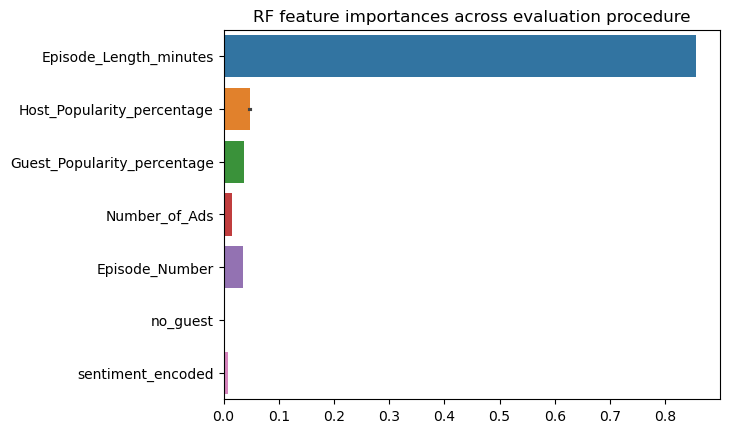

In [14]:
rf_importance(models_rf_abs, X_only_numeric.columns)

## Sobre target relativo

In [15]:
res_rf_rel, models_rf_rel = cv_model(
    lambda **kwargs: RandomForestRegressor(**kwargs), 
    X=X_only_numeric,
    is_rel=True,
    model_args=dict(n_jobs=-1)
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
res_rf_rel

,mae,mse,rmse
0,9.074890,134.183722,11.583770
1,8.875979,130.128694,11.407396
2,8.972278,132.425665,11.507635
3,8.952833,131.801773,11.480495
4,9.047133,133.496857,11.554084
mean,8.984623,132.407342,11.506676
std,0.079092,1.573360,0.068436


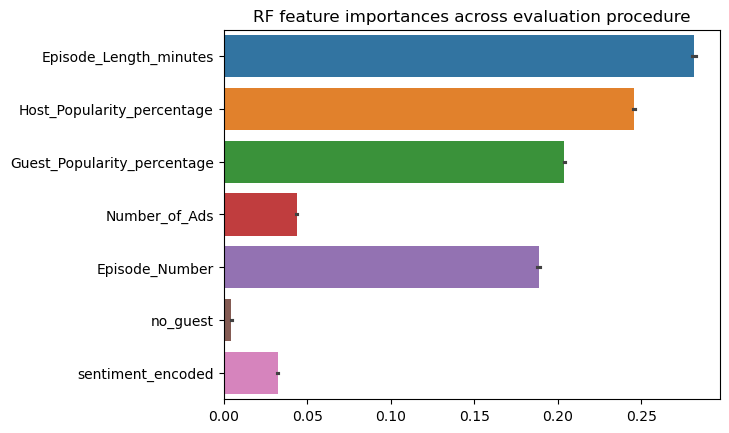

In [17]:
rf_importance(models_rf_rel, X_only_numeric.columns)

Se observa que la diferencia en performance entre usar target relativo y absoluto es mínima, aunque favorece levemente al target relativo.

Sin embargo, debe destacarse que el modelo con target relativo utiliza mucho mejor las diferentes features, mientras que el absoluto se concentra casi exclusivamente en la duración del podcast.

# Baseline + variables categóricas

## One Hot Encoding

In [18]:
res_onehot_rel, models_onehot_rel = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',numeric_cols),
            (OneHotEncoder(sparse_output=False), cat_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
res_onehot_rel

,mae,mse,rmse
0,9.016434,131.408208,11.463342
1,8.848748,127.525894,11.292736
2,8.831355,128.307383,11.327285
3,8.871610,127.558103,11.294162
4,8.898732,128.087203,11.317562
mean,8.893376,128.577358,11.339017
std,0.073287,1.617970,0.071078


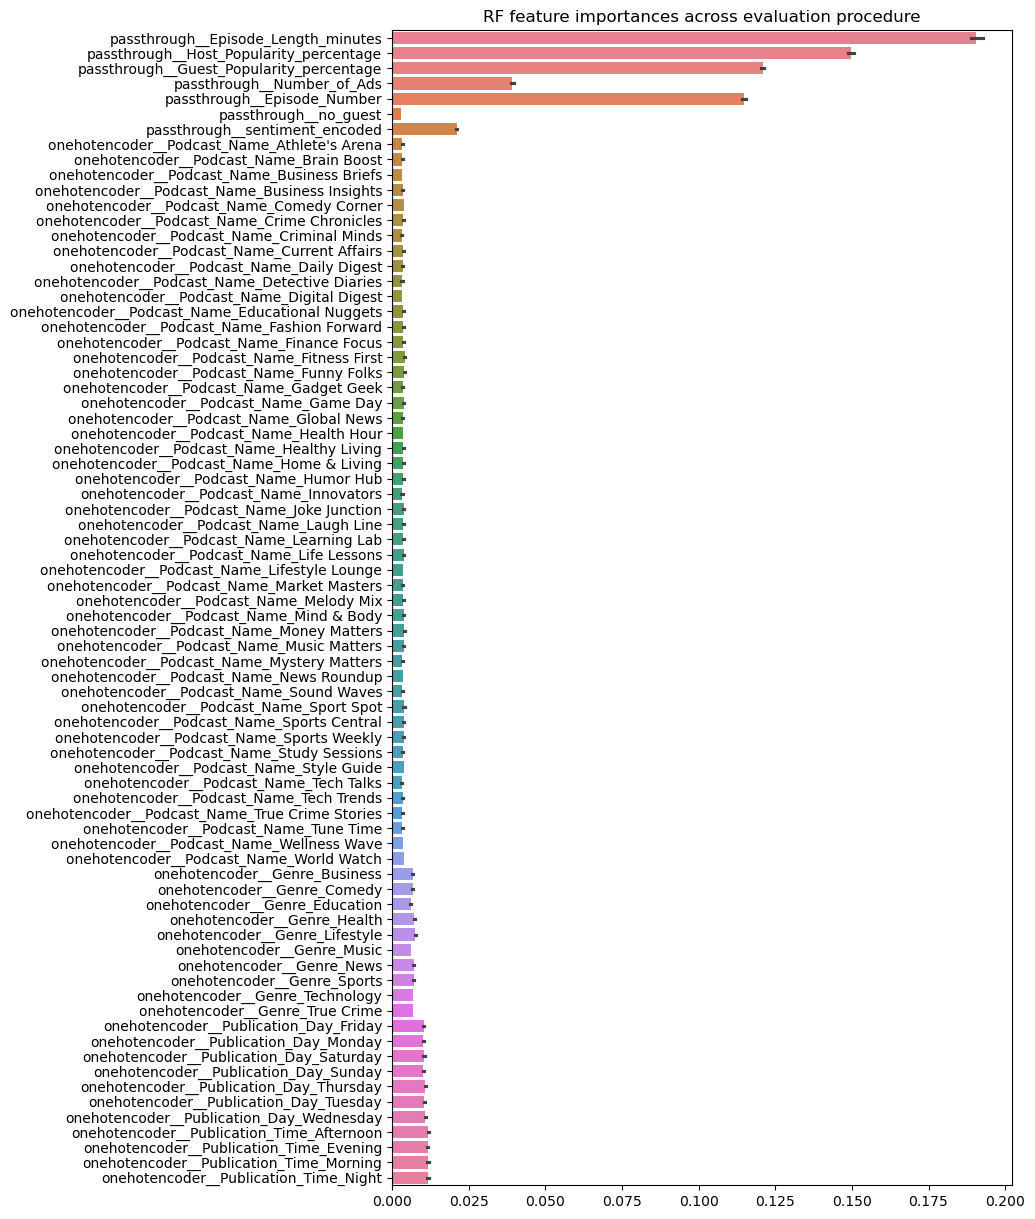

<Figure size 640x480 with 0 Axes>

In [20]:
fig, ax = plt.subplots(figsize=(8,15))
rf_importance(models_onehot_rel, models_onehot_rel[0][-2].get_feature_names_out())
plt.tight_layout()

## Target Encoding

In [21]:
res_tgt_rel, models_tgt_rel = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',numeric_cols),
            (TargetEncoder(target_type='continuous', random_state=42), cat_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [22]:
res_tgt_rel

,mae,mse,rmse
0,8.937606,129.303380,11.371164
1,8.836557,127.204078,11.278479
2,8.839088,127.724849,11.301542
3,8.849722,126.178094,11.232902
4,8.914023,128.372299,11.330150
mean,8.875399,127.756540,11.302847
std,0.047032,1.179998,0.052203


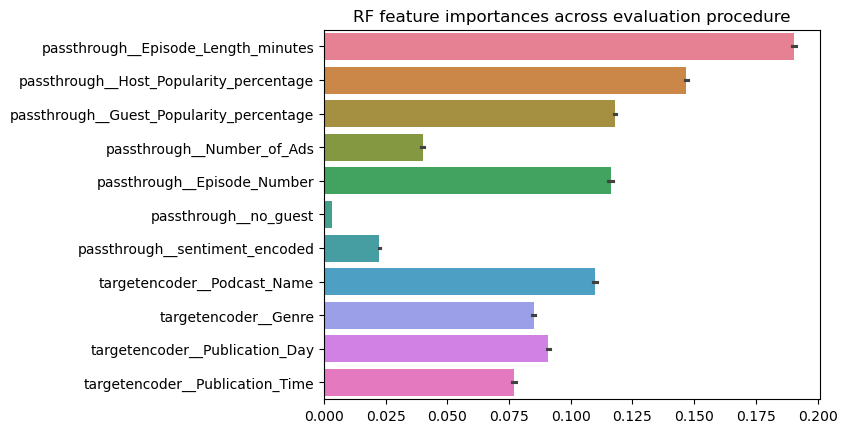

In [23]:
rf_importance(models_tgt_rel, models_tgt_rel[0][-2].get_feature_names_out())

Como se puede observar, la performance de las categorías encodeadas vía Target Encoding es superior a la de One Hot Encoding, incluso para aquellas de baja cardinalidad. Cabe destacar que el Target Encoder tiene hiperparámetros que no han sido tuneados, se están utilizando los default.

# Feature Engineering

In [24]:
# cantidad media de ads por minuto 
X['ad_density'] = X['Number_of_Ads'] / X['Episode_Length_minutes']

# popularidad sumada de Host y Guest
X['joint_popularity'] = X['Host_Popularity_percentage'] + X['Guest_Popularity_percentage']

# como son pocas categóricas, se pueden hacer combinaciones y luego encodearlas por algún tipo de target encoding
for n in range(2,len(cat_cols)+1):
    for cols in combinations(cat_cols,n):
        cols_list = list(cols) # pandas gets angry if they're tuples instead of lists
        X[f"comb_{n}_"+"+".join(cols)] = X[cols_list].apply(lambda s: '-'.join(s), axis=1)

NameError: name 'combinations' is not defined

In [25]:
comb_cols = X.columns[X.columns.str.startswith('comb_')].tolist()

In [26]:
# a ver como se ve
X.head().T

,0,1,2,3,4
Podcast_Name,Healthy Living,Mystery Matters,Current Affairs,Mystery Matters,Money Matters
Episode_Length_minutes,99.25,19.43,117.03,16.97,28.06
Genre,Health,True Crime,News,True Crime,Business
Host_Popularity_percentage,21.37,47.19,96.33,25.73,22.02
Publication_Day,Thursday,Friday,Sunday,Monday,Wednesday
Publication_Time,Night,Evening,Night,Night,Morning
Guest_Popularity_percentage,70.22,75.15,57.95,24.19,-1.0
Number_of_Ads,3,1,3,0,1
Episode_Number,77,6,1,38,87
no_guest,False,False,False,False,True


Probamos su importancia utilizando un Random Forest con Target Encoding y valores default como antes.

In [27]:
res_fe_rel, models_fe_rel = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',X.columns[X.dtypes != 'object']),
            (TargetEncoder(target_type='continuous', random_state=42), cat_cols+comb_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [28]:
res_fe_rel

,mae,mse,rmse
0,8.968517,129.967659,11.400336
1,8.835218,126.966684,11.267949
2,8.850693,127.574854,11.294904
3,8.862960,126.706119,11.256381
4,8.930239,128.663540,11.342995
mean,8.889526,127.975771,11.312513
std,0.057141,1.344586,0.059348


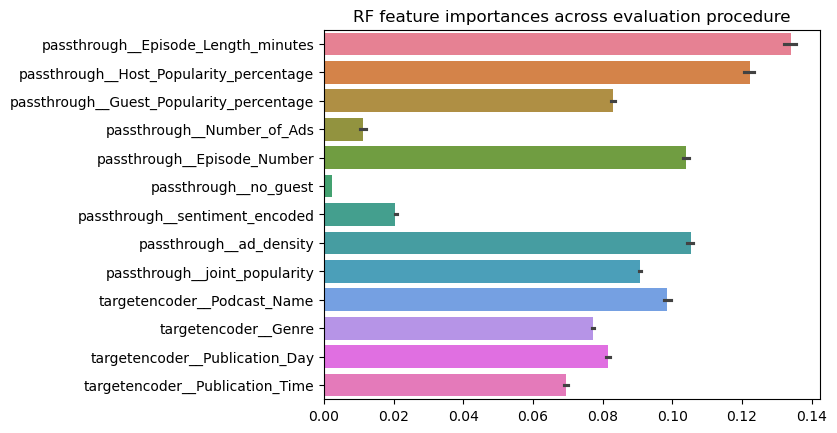

In [29]:
rf_importance(models_fe_rel, models_fe_rel[0][-2].get_feature_names_out())

Como se puede apreciar, con las nuevas variables el RMSE baja de 11.31 a 11.23 y el MAE de 8.88 a 8.83 (en media sobre 5 folds). Además la importancia de las variables es bastante alta y con poca variabilidad entre folds, lo que indica que tienen poder predictivo.

Por completitud se estima la performance utilizando target absoluto:

In [30]:
res_fe_abs, models_fe_abs = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',X.columns[X.dtypes != 'object']),
            (TargetEncoder(target_type='continuous', random_state=42), cat_cols+comb_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=False
)

res_fe_abs

  0%|          | 0/5 [00:00<?, ?it/s]

,mae,mse,rmse
0,8.962463,130.589723,11.427586
1,8.818191,126.504907,11.247440
2,8.843261,128.352346,11.329269
3,8.882134,128.187528,11.321993
4,8.925643,129.275874,11.369955
mean,8.886338,128.582076,11.339249
std,0.058858,1.502920,0.066281


Como era de esperarse, la performance es peor. Se confirma entonces qeu es mejor utilizar el target relativo.

# Testeo de diferentes modelos

**TO DO PROBAR DIFERENTES MODELOS CON VALORES DEFAULT**

* Ridge
* LASSO
* SVR
* LightGBM (probablemente el que mejor ande, probar usando su propio encoding en vez del Tgt Enc)

In [31]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

def make_preprocessed_pipeline(model, numeric_cols, cat_cols):
    preprocessor = make_column_transformer(
        ('passthrough', numeric_cols),
        (OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        remainder='drop',
        sparse_threshold=0,
        n_jobs=-1
    )
    
    return make_pipeline(preprocessor, StandardScaler(), model)

In [38]:
from sklearn.linear_model import Lasso, Ridge
res_lasso_rel, models_lasso_rel = cv_model(
    lambda: make_preprocessed_pipeline(Lasso(alpha=0.1), numeric_cols, cat_cols),
    X=X,
    is_rel=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [39]:
res_lasso_rel

,mae,mse,rmse
0,9.209609,140.167239,11.839225
1,9.085107,136.077064,11.665207
2,9.125548,137.878952,11.742187
3,9.181672,137.886407,11.742504
4,9.198843,138.803393,11.781485
mean,9.160156,138.162611,11.754122
std,0.052998,1.494607,0.063589


In [40]:
res_ridge_rel, models_ridge_rel = cv_model(
    lambda: make_preprocessed_pipeline(Ridge(alpha=1.0), numeric_cols, cat_cols),
    X=X,
    is_rel=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [41]:
res_ridge_rel

,mae,mse,rmse
0,8.877918,126.952204,11.267307
1,8.752063,123.962696,11.133854
2,8.804853,125.246857,11.191374
3,8.796154,124.144580,11.142019
4,8.856516,125.605072,11.207367
mean,8.817501,125.182282,11.188384
std,0.050175,1.212411,0.054133


In [42]:
from sklearn.svm import SVR

res_svr_rel, models_svr_rel = cv_model(
    lambda: make_preprocessed_pipeline(SVR(C=1.0, epsilon=0.1), numeric_cols, cat_cols),
    X=X,
    is_rel=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [43]:
res_svr_rel

,mae,mse,rmse
0,9.206676,140.093226,11.836098
1,9.051417,135.979611,11.661030
2,9.035585,136.853457,11.698438
3,9.016949,134.925157,11.615729
4,9.156031,139.019426,11.790650
mean,9.093332,137.374175,11.720389
std,0.083223,2.139727,0.091220


In [44]:
# ejemplo de LightGBM
from lightgbm import LGBMRegressor

X_cats = X.copy()

for col in cat_cols+comb_cols:
    X_cats[col] = X_cats[col].astype("category")

X_cats.info()

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
res_lgb_rel, models_lgb_rel = cv_model(
    lambda : LGBMRegressor(num_leaves=31, max_bin=2048, subsample=1., subsample_freq=8, colsample_bytree=0.9),
    X=X_cats,
    is_rel=True
)

In [ ]:
res_lgb_rel

In [ ]:
rf_importance(models_lgb_rel, X_cats.columns)

Parece que anda mal por insistencia en concentrarse en las mismas features, tal vez por eso anda mejor el RF? Ver los demás.


**TO DO HACER MINI FEATURE SELECTION Y HP TUNING SI ES POSIBLE CON OPTUNA Y W&B**

Nota martín: lo que yo creo que habría que hacer:

* Probar diferentes modelos con valores default sobre todas las variables
* Alguno de esos va a andar notablemente mejor que los demás (seguramente LightGBM)
* Agarrar el que sea preferible y hacer backward selection probando de dropear `Number_of_Ads`, `no_guest` y `sentiment_encoded` a ver si la performance mejora (recordar que estamos midiendo RMSE)
* Ahí hacer HP tuning con optuna y w&b

Recordar que LightGBM usa su propio target encoder, ver [ref](https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor) e [integr con optuna](https://optuna-integration.readthedocs.io/en/stable/reference/index.html#lightgbm).